In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
df.dropna(inplace=True)

df = pd.get_dummies(df, columns=["League","Division","NewLeague"])

df.drop(["League_N", "Division_W", "NewLeague_N"], axis=1, inplace=True)

df.replace(to_replace=False, value=0, inplace=True)
df.replace(to_replace=True, value=1, inplace=True)

df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_A,Division_E,NewLeague_A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,0,0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,1,0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,0,1,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,0,1,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,1,0,1


In [4]:
X = df.drop("Salary", axis=1)
y = df[["Salary"]]
X.shape, y.shape

((263, 19), (263, 1))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=16)

In [6]:
gbm_model = GradientBoostingRegressor().fit(X_train, y_train)

In [7]:
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [8]:
y_pred = gbm_model.predict(X_test)

In [9]:
r2_score(y_test, y_pred)

0.725336663448971

In [10]:
np.sqrt(mean_squared_error(y_test, y_pred))

245.24550721826293

In [11]:
# Model Tuning

In [12]:
gbm_params = {
    "learning_rate": [0.01, 0.1, 0.5],
    "max_depth": [3, 5],
    "n_estimators": [100, 200, 500],
    "subsample": [1, 0.5],
    "loss": ["ls", "lad", "quantile"]
}

gbm_cv = GridSearchCV(GradientBoostingRegressor(), gbm_params, cv=10, n_jobs=-1, verbose=2)
gbm_cv.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'loss': ['ls', 'lad', 'quantile'], 'max_depth': [3, 5],
                         'n_estimators': [100, 200, 500],
                         'subsample': [1, 0.5]},
             verbose=2)

In [14]:
gbm_cv.best_params_

{'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 5,
 'n_estimators': 500,
 'subsample': 0.5}

In [15]:
# Model Tuning

In [18]:
gbm_tuned = GradientBoostingRegressor(
    learning_rate=0.1,
    loss="quantile",
    max_depth=5,
    n_estimators=500,
    subsample=0.5
).fit(X_train, y_train)

In [19]:
y_pred = gbm_tuned.predict(X_test)

In [20]:
r2_score(y_test, y_pred)

0.7441619158508082

In [21]:
np.sqrt(mean_squared_error(y_test, y_pred))

236.6918539625602

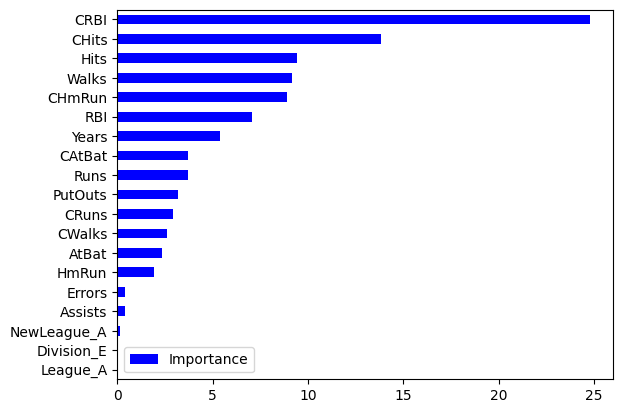

In [23]:
# Değişkemlerin önem düzeylerini gösteren bir grafik
pd.DataFrame(
    {"Importance":gbm_model.feature_importances_*100}, 
    index=X_train.columns
).sort_values(
    by="Importance", 
    axis=0, 
    ascending=True
).plot(
    kind="barh", 
    color="b");